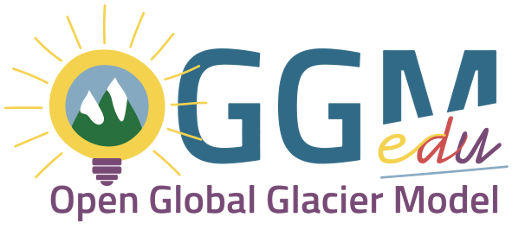

# Glacier surging experiments

Goals of this notebook:

- The student will be able to describe the effects of glacier surging.

- The student will be able to implement glacier surging in OGGM.

In this notebook we are going to explore the basic functionalities of OGGM flowline model(s) and perform a simple surging experiment. For this purpose we are going to use simple and "idealized" glacier models with simple linear mass-balance profiles. 

##### What is glacier surging?
A small percentage of glaciers undergo short periods of faster flow. They experience a change in morphology and surface characteristics, which sometimes leads to a marked frontal advance. The speed of the ice increases up to 10 - 1000 times of the normal velocity. Record flows are observed with velocities that exceed 100m per day. Surges happen in decadal cycles and can last for 1 up to 15 years.[¹](#Reference)

We start with importing all needed modules:

In [1]:
# The commands below are just importing the necessary modules and functions
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size

# Scientific packages
import numpy as np

# Constants
from oggm import cfg
cfg.initialize()
# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel, RectangularBedFlowline, TrapezoidalBedFlowline, ParabolicBedFlowline

# There are several solvers in OGGM core. We use the default one for this experiment
from functools import partial
FlowlineModel = partial(FluxBasedModel, min_dt=0, cfl_number=0.01)

# OGGM Edu helper functions
import oggm_edu as edu

2019-05-16 18:01:26: oggm.cfg: Using configuration file: C:\Program Files\Miniconda3\envs\oggm_env\lib\site-packages\oggm\params.cfg


## Basics

First we set-up a simple run with a constant linear bedrock and a grid. We do similiar steps like in [flowline_model](http://edu.oggm.org/en/latest/notebooks_flowline_intro.html#glacier-flowline-modelling) to generate a set-up for our experiment.

In [2]:
# This is the bed rock, linearily decreasing from 3400 m altitude to 1400 m, in 200 steps
nx = 200
bed_h = np.linspace(3400, 1400, nx)
# At the beginning, there is no glacier so our glacier surface is at the bed altitude
surface_h = bed_h
# Let's set the model grid spacing to 100 m 
map_dx = 100
# Calculate the corresponding distance along the glacier (from the top)
distance_along_glacier = np.linspace(0, nx, nx) * 0.1 # in km 
# The units of widths is in "grid points", i.e. 3 grid points = 300 m in our case
widths = np.zeros(nx) + 3.
# Define our bed
init_flowline = RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

Then we define the equilibrium line altitude (ELA) for the mass balance model:

In [3]:
# ELA at 3000m a.s.l., gradient 4 mm m-1
mb_model = LinearMassBalance(3000, grad=4)

Here we calculate a glacier that flows only because of deformation and  without sliding:

In [4]:
# Define for how many years the glacier should be calculated
years = 600
# Initialize the model with the following function 
model = edu.init_model(init_flowline, mb_model=mb_model, years= years)
# Store the outline of the glacier as simple_glacier_h
simple_glacier_h = model.fls[-1].surface_h

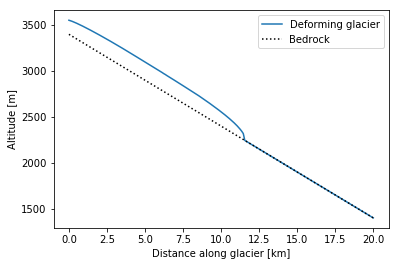

In [5]:
# Let's plot it!
plt.plot(distance_along_glacier, simple_glacier_h, label='Deforming glacier')
edu.plot_xz_bed(distance_along_glacier, bed_h)

## Surging glacier experiment

Since surging occurs because of increased basal sliding, a surging period can be represented in the model by increasing the sliding parameter[¹](#Reference), for example by a factor of 10. Typically surging can be assumend to happen cyclically after 100 years of normal sliding and lasts over a period of 10 years.

Let's model a simple glacier that only slides:

In [6]:
# Define parameters:
# Default in OGGM: Glen's creeping parameter
A = cfg.PARAMS['glen_a']
# Sliding glaciers (sliding parameter fs is nonzero)
fs = 5.7e-20
# Define for how many years the glacier should be calculated
years = 600

In [7]:
# Initialize the model
model = edu.init_model(init_flowline, mb_model=mb_model, years=years, fs=fs)
# I store the final results for later use
sliding_glacier_h = model.fls[-1].surface_h

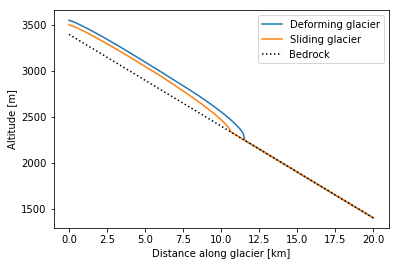

In [8]:
# Let's plot both models.
plt.plot(distance_along_glacier, simple_glacier_h, label='Deforming glacier')
plt.plot(distance_along_glacier, sliding_glacier_h, label='Sliding glacier')
edu.plot_xz_bed(distance_along_glacier, bed_h)

Now we calculate a surging glacier:

In [9]:
# Define parameters:
# Sliding parameter in times of slow sliding:
fs = 5.7e-20
# Sliding parameter in surging periods:
fs_surge = 5.7e-20*10
# Surging period (years):
period_s = 10
# Time span between 2 surging periods (years):
t_slow = 100
# Number of surges
no_surges = 10

In [10]:
# Surging glaciers - model initialisation
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0., glen_a=A, fs=fs)

# 10 periods of 10 years surging every 100 years
yrs = np.arange(0, t_slow + 1, 10)
for i in np.arange(0, no_surges, 1):
    yrs_sliding = np.arange(t_slow+1+t_slow*i+period_s*i, t_slow+period_s+1+t_slow*i+period_s*i,1)
    yrs = np.append(yrs, yrs_sliding)
    
    yrs_normal = np.arange(t_slow+period_s+10+t_slow*i+period_s*i, 2*t_slow+period_s+10+t_slow*i+period_s*i, 10)
    yrs = np.append(yrs, yrs_normal)

If it is still unclear to you which years are "surging years", have a look into the list "yrs":

In [11]:
yrs

array([   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
        101,  102,  103,  104,  105,  106,  107,  108,  109,  110,  120,
        130,  140,  150,  160,  170,  180,  190,  200,  210,  211,  212,
        213,  214,  215,  216,  217,  218,  219,  220,  230,  240,  250,
        260,  270,  280,  290,  300,  310,  320,  321,  322,  323,  324,
        325,  326,  327,  328,  329,  330,  340,  350,  360,  370,  380,
        390,  400,  410,  420,  430,  431,  432,  433,  434,  435,  436,
        437,  438,  439,  440,  450,  460,  470,  480,  490,  500,  510,
        520,  530,  540,  541,  542,  543,  544,  545,  546,  547,  548,
        549,  550,  560,  570,  580,  590,  600,  610,  620,  630,  640,
        650,  651,  652,  653,  654,  655,  656,  657,  658,  659,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  761,
        762,  763,  764,  765,  766,  767,  768,  769,  770,  780,  790,
        800,  810,  820,  830,  840,  850,  860,  8

In [12]:
# Calculation of the glacier outline after going through the chosen number of surges
surging_model = edu.surging_glacier(yrs, init_flowline, mb_model, bed_h, widths, map_dx, A, fs, fs_surge, model)
surging_glacier_h_weak = surging_model[0].fls[-1].surface_h

C:\Program Files\Miniconda3\envs\oggm_env\lib\site-packages\oggm\core\flowline.py:622: RuntimeWarning: overflow encountered in long_scalars
  t = (y1-self.y0) * SEC_IN_YEAR


In the next figures the development of the glacier (length and volume) over the years is shown:

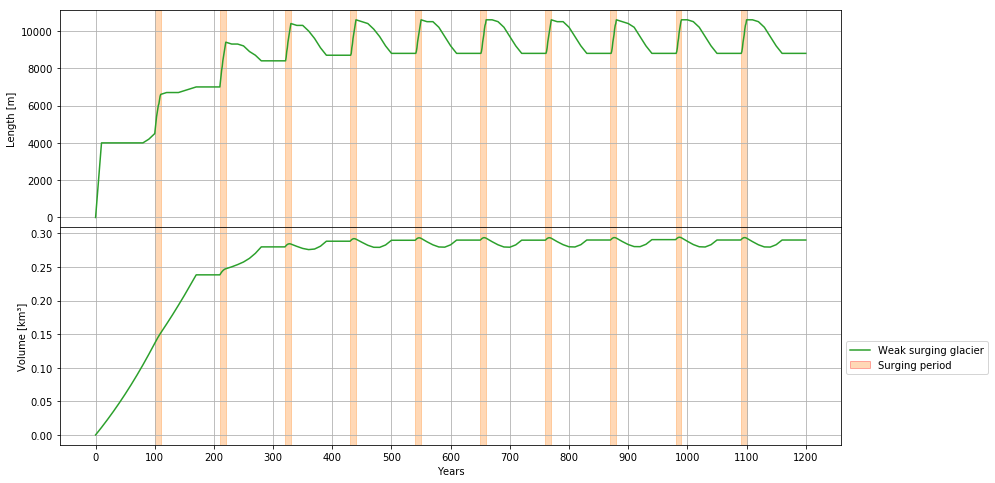

In [13]:
# Plot it in two subplots
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(14, 8))
fig.subplots_adjust(hspace=0)
plt.xlabel('Years')
plt.xticks(np.arange(min(yrs), max(yrs)+1, 100.0))
# Glacier length
axs[0].plot(yrs, surging_model[2], color='tab:green')
# Mark surging periods
for i, yr in enumerate(yrs):
    if (yr-yrs[i-1]) ==  1 and (yrs[i-1+period_s]-yrs[i+period_s-2]) == 1:
        axs[0].axvspan(yrs[i-1], yrs[i-1+period_s], color='tab:orange', alpha=0.3)
axs[0].set_ylabel('Length [m]')
axs[0].grid()

# Glacier volume
axs[1].plot(yrs, surging_model[3], color='tab:green')
# Mark surging periods
for i, yr in enumerate(yrs):
    if (yr-yrs[i-1]) ==  1 and (yrs[i-1+period_s]-yrs[i+period_s-2]) == 1:
        axs[1].axvspan(yrs[i-1], yrs[i-1+period_s], color='tab:orange', alpha=0.3)
axs[1].set_ylabel('Volume [km³]')
axs[1].grid()
# Define labels and add a legend
label = [Line2D(yrs, surging_model[3], color='tab:green', label='Weak surging glacier'),
         Patch(facecolor='tab:orange', alpha=0.3, edgecolor='r', label='Surging period')]
axs[1].legend(handles=label, bbox_to_anchor=(1, 0.5));

Now we compare the different calculated glacier:

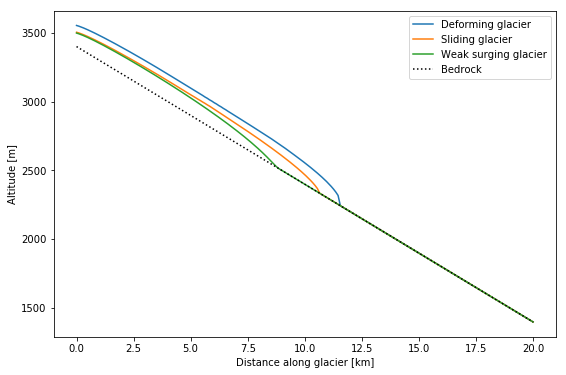

In [14]:
# Plot the results
f, ax = plt.subplots(figsize=(9, 6))
plt.plot(distance_along_glacier, simple_glacier_h, label='Deforming glacier')
plt.plot(distance_along_glacier, sliding_glacier_h, label='Sliding glacier')
plt.plot(distance_along_glacier, surging_glacier_h_weak, label='Weak surging glacier')
# Add the bedrock
edu.plot_xz_bed(distance_along_glacier, bed_h)

We now increase the sliding parameter in order to increase surges:

In [15]:
# Define parameters:
# Sliding parameter in times of normal sliding:
fs = 5.7e-20
# Sliding parameter in surging periods:
fs_surge = 5.7e-20*50

# Calculation of the glacier outline
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0., glen_a=A, fs=fs)
strong_surge_model = edu.surging_glacier(yrs, init_flowline, mb_model, bed_h, widths, map_dx, A, fs, fs_surge, model)
surging_glacier_h = strong_surge_model[0].fls[-1].surface_h

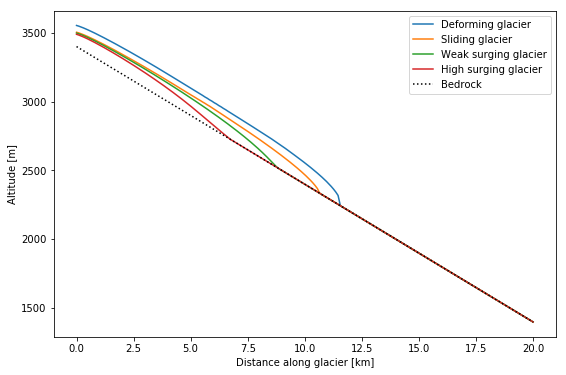

In [16]:
# Plot the results
f, ax = plt.subplots(figsize=(9, 6))
plt.plot(distance_along_glacier, simple_glacier_h, label='Deforming glacier')
plt.plot(distance_along_glacier, sliding_glacier_h, label='Sliding glacier')
plt.plot(distance_along_glacier, surging_glacier_h_weak, label='Weak surging glacier')
plt.plot(distance_along_glacier, surging_glacier_h, label='High surging glacier')
# Add the bedrock
edu.plot_xz_bed(distance_along_glacier, bed_h)

Compare the different glacier types. How can you explain the differences?

In the next plot the development of the weak surging glacier and the high surging glacier are shown:

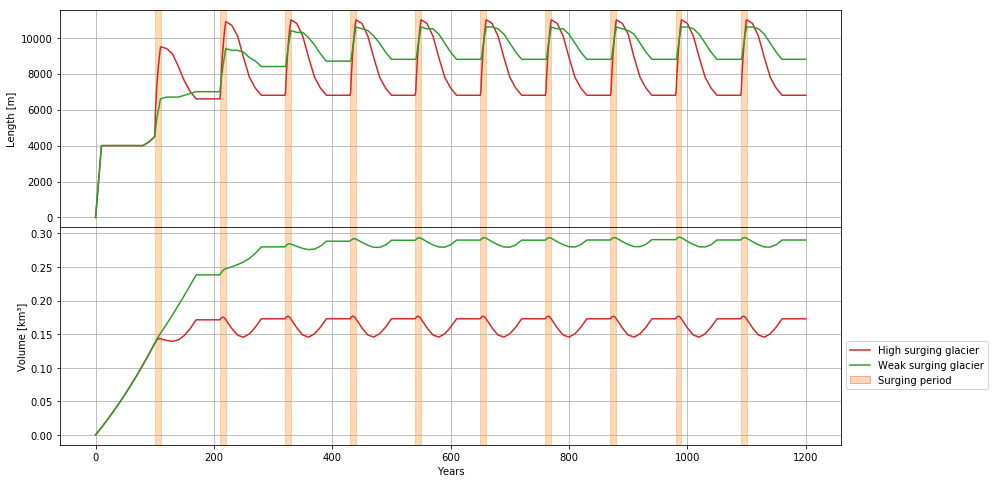

In [17]:
# Plot it in two subplots
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(14, 8))
fig.subplots_adjust(hspace=0)
plt.xlabel('Years')
# Glacier length        
axs[0].plot(yrs, strong_surge_model[2], color='tab:red')
axs[0].plot(yrs, surging_model[2], color='tab:green')
# Mark surging periods
for i, yr in enumerate(yrs):
    if (yr-yrs[i-1]) ==  1 and (yrs[i-1+period_s]-yrs[i+period_s-2]) == 1:
        axs[0].axvspan(yrs[i-1], yrs[i-1+period_s], color='tab:orange', alpha=0.3)
axs[0].set_ylabel('Length [m]')
axs[0].grid()

# Glacier volume
axs[1].plot(yrs, strong_surge_model[3], color='tab:red')
axs[1].plot(yrs, surging_model[3], color='tab:green')
# Mark surging periods
for i, yr in enumerate(yrs):
    if (yr-yrs[i-1]) ==  1 and (yrs[i-1+period_s]-yrs[i+period_s-2]) == 1:
        axs[1].axvspan(yrs[i-1], yrs[i-1+period_s], color='tab:orange', alpha=0.3)
axs[1].set_ylabel('Volume [km³]')
axs[1].grid()
# Define labels and add a legend
label = [Line2D(yrs, strong_surge_model[3], color='tab:red', label='High surging glacier'), 
         Line2D(yrs, surging_model[3], color='tab:green', label='Weak surging glacier'),
         Patch(facecolor='tab:orange', alpha=0.3, edgecolor='r', label='Surging period')]
axs[1].legend(handles=label, bbox_to_anchor=(1, 0.5));

## Reference

¹ Hester Jiskoot: Glacier Surging. In: Vijay P. Singh, Pratap Singh, Umesh K. Haritashya (Hrsg.): Encyclopedia of Snow, Ice and Glaciers. Springer, Dordrecht 2011, S. 415–428, ISBN 978-90-481-2641-5

## What's next?
[Back to table of contents](welcome.ipynb) or [notebook: Mass balance gradients](mass_balance_gradients.ipynb)